In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [98]:
data = pd.DataFrame.from_csv('data_n2.tsv', sep='\t')
data = data.drop('probability_ordered', axis=1) # we ignore col 'probability_ordered

In [4]:
data.head(5)

,target_article_id,target_article_name,probability,target_position_in_text,target_position_in_section,target_in_table,target_position_in_text_normed,target_position_in_section_normed,source_article_max_section_number,source_article_max_number_of_links
source_article_id,,,,,,,,,,
27275061,1946322,Katipo,0.705357,8,8,0.0,0.195122,0.727273,6,41
27275061,1946322,Latrodectus katipo,0.294643,29,14,0.0,0.707317,0.608696,6,41
18328851,16562095,Sino Land Company Limited,0.575000,14,14,0.0,0.736842,0.875000,3,19
18328851,20477410,Sino Hotels (Holdings) Limited,0.545455,15,15,0.0,0.789474,0.937500,3,19
18328851,16562095,Sino Land,0.425000,18,2,0.0,0.947368,0.666667,3,19


In [5]:
samples, feats = data.shape
print("num of samples: {}, num of features: {}".format(samples, feats-1))

num of samples: 205278, num of features: 9


# Features

Let's have a look at the features

,features,correlation
0,target_article_id,6.564554e-17
2,target_position_in_text,-1.002721e-01
3,target_position_in_section,-4.167372e-02
4,target_in_table,-1.321881e-01
5,target_position_in_text_normed,-1.948319e-01
6,target_position_in_section_normed,5.278587e-02
7,source_article_max_section_number,6.054259e-17
8,source_article_max_number_of_links,1.843562e-17


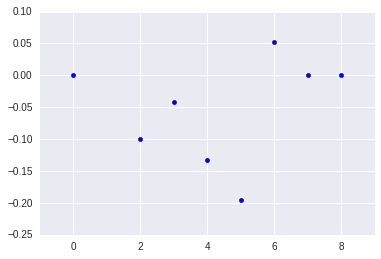

In [6]:
corr_matrix = data.corr(method='pearson') # correlation matrix between all cols

corr_target = corr_matrix.probability.to_frame().reset_index()
corr_target.columns = ['features', 'correlation']
# drop the row for the correlation of probability with itself
corr_target = corr_target[corr_target.features != 'probability'] 
plt.scatter(corr_target.index, corr_target.correlation)
corr_target

So with the text feature dropped, we only have 8 features left, and out of those 3 show a 0 correlation value with the target. 

Of these three, the `target_article_id` makes sense, since it will be different for each target link, and point to at least two different probability values. The different IDs have no ordered relation between themselves.

On the other hand, the virtually zero correlation values for `source_article_max_section_number` and `source_article_max_number_of_links` is surprising. By themselves, these features tell us nothing about the target data.

The most informative feature is `target_position_in_text_normed` at close to $-0.20$ correlation. This seems reasonable, as one might assume users tend to click on earlier links rather than later ones.

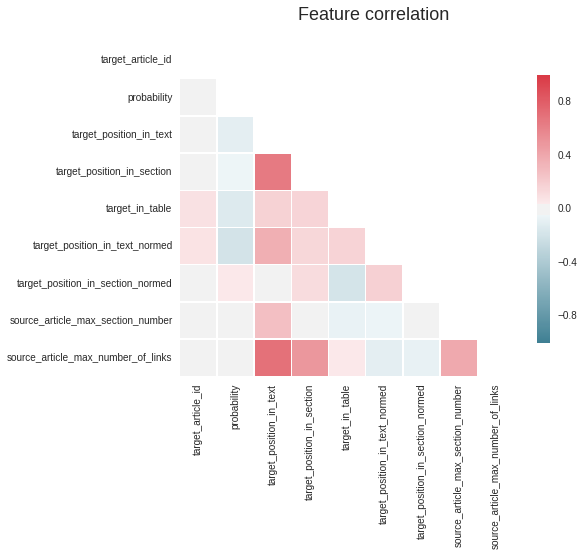

In [51]:
def correlation_matrix(corr, title):
    """Plot the pairwise correlations in corr matrix""" 
    sns.set_style("whitegrid")
    # Generate a mask for the upper triangle 
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
 
    # Set up the matplotlib figure 
    f, ax = plt.subplots(figsize=(8, 6))
 
    # Generate a custom diverging colormap 
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
 
    # Ddata the heatmap with the mask and correct aspect ratio 
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, square=True,
                linewidths=.5, cbar_kws={"shrink": .8}, ax=ax)
 
    # Set title 
    f.suptitle(title, fontsize=18)
    sns.set_style('darkgrid')
    
correlation_matrix(corr_matrix, "Feature correlation")

On top of the findings on correlation to the target value, the features are mostly very weakly correlated amongst themselves, as we can see with the correlation matrix above. Notable exceptions are `target_position_in_text` with `target_position_in_section` and `target_position_in_text` and `source_article_max_number_of_links`.

Now, in order to better understand the feature's relations to the target value, let's look at each one's relation to the target value more closely.

## Feature `target_position_in_text`

Below is a jointplot (scatterplot and histograms) for `probability` vs `target_position_in_text`. 

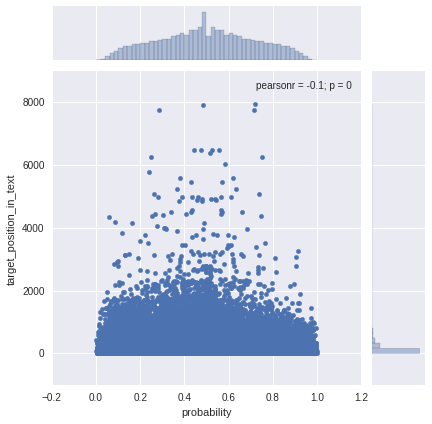

In [66]:
sns.jointplot(x='probability', y='target_position_in_text', data=data)

Since the values of the `target_position_in_text` feature values lie mainly in the interval $[0,2000]$, let's do the same, but getting rid of all data points above the 90th percentile, and this time using a kernel density estimation and contour plot.

/home/alexis/Applications/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


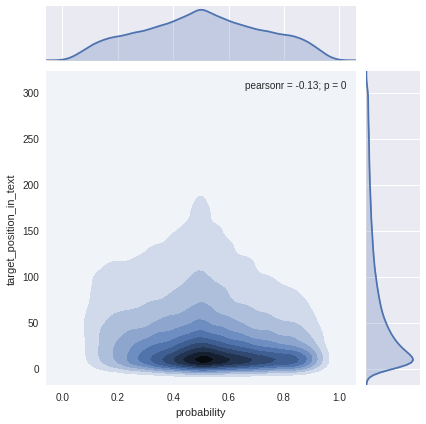

In [96]:
data_filt = data[data.target_position_in_text < data.target_position_in_text.quantile(.9)]
sns.jointplot(x='probability', y='target_position_in_text', data=data_filt, kind='kde');

## Feature `target_position_in_section`

Similarly for feature `target_position_in_section`

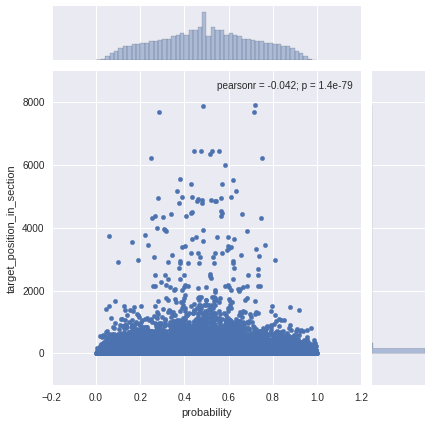

In [88]:
sns.jointplot(x='probability', y='target_position_in_section', data=data)

Similarly to above, most of the values of the `target_position_in_section` feature seem to lie in the $[0,1000]$ range, so we'll again do the same for the 70th percentile.

/home/alexis/Applications/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


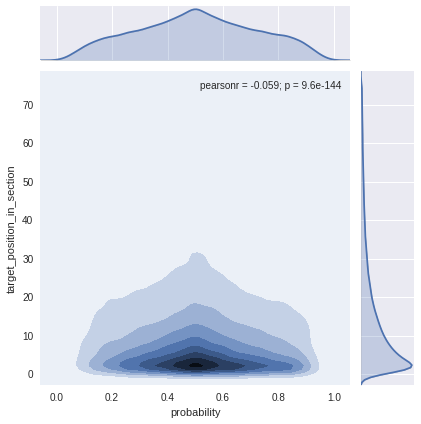

In [104]:
data_filt = data[data.target_position_in_section < data.target_position_in_section.quantile(.9)]
sns.jointplot(x='probability', y='target_position_in_section', data=data_filt, kind='kde');

## Feature `target_position_in_text_normed`

Similarly for feature `target_position_in_text_normed`

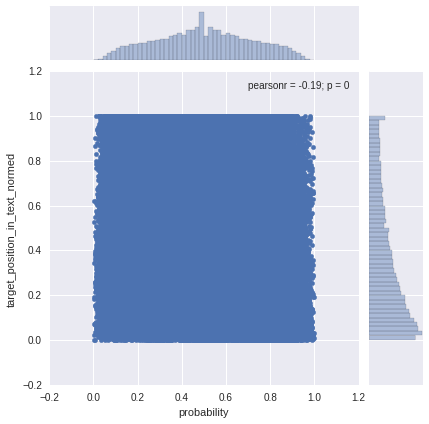

In [105]:
sns.jointplot(x='probability', y='target_position_in_text_normed', data=data)

In this case, the scatter plot doesn't tell us much, since the data points are densely distributed over the whole are of the plot. Let's look at the contour plot for the whole set in this case.

/home/alexis/Applications/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


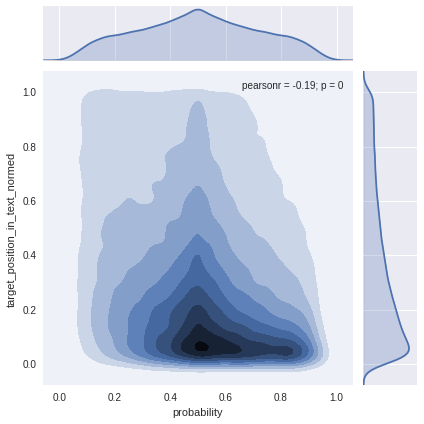

In [113]:
sns.jointplot(x='probability', y='target_position_in_text_normed', data=data_filt, kind='kde');

## Feature `target_position_in_section_normed`
Similarly for feature `target_position_in_section_normed`


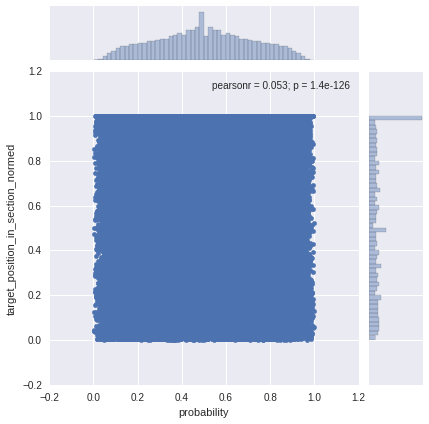

In [107]:
sns.jointplot(x='probability', y='target_position_in_section_normed', data=data)

Again, the scatter plot doesn't tell us much, but the histogram indicates that there's many of the target links are the last ones appearing in their section. The distribution is almost constant for the rest of the values.  

We can have a look at the contour plot again to get more insight.

/home/alexis/Applications/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


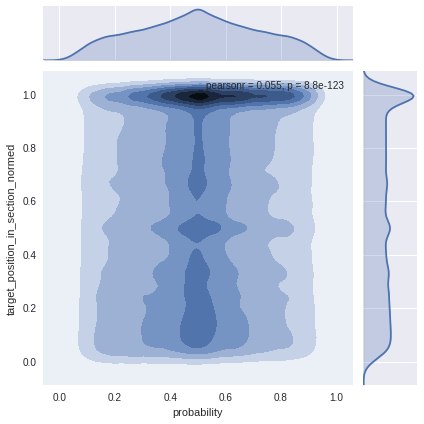

In [116]:
sns.jointplot(x='probability', y='target_position_in_section_normed', data=data_filt, kind='kde');

## Feature `source_article_max_section_number`

Similarly for feature `source_article_max_section_number`


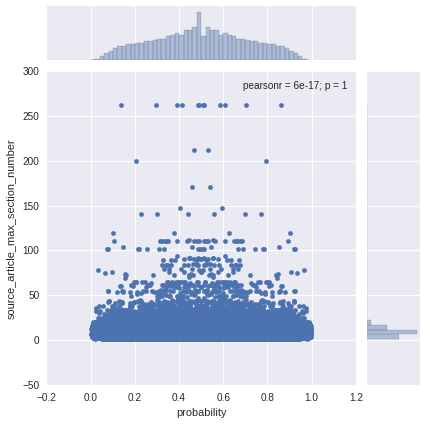

In [109]:
sns.jointplot(x='probability', y='source_article_max_section_number', data=data)

The histogram shows that there are very few values with more than 15 sections in their article. In fact

In [128]:
quant=.9
print(quant*100, "% of the data points have less than", 
      data.source_article_max_section_number.quantile(.90), "sections")

90.0 % of the data points have less than 14.0 sections


So let's look at the boxplots for the data points within the 90th percentile.

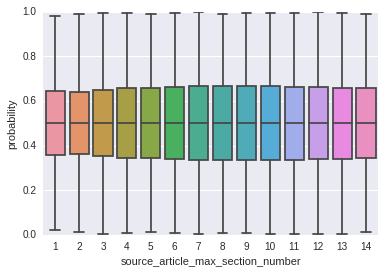

In [134]:
sns.boxplot(x="source_article_max_section_number", y="probability", 
            data=data[data.source_article_max_section_number <= data.source_article_max_section_number.quantile(quant)]);

From this we can see that there is no great variation amongst these different values. All the medians seem to be almost exactly at 0.5, and there is some slight variation between the first and third quartiles of the different categories.

## Feature `source_article_max_number_of_links`

Similarly for feature `source_article_max_number_of_links`


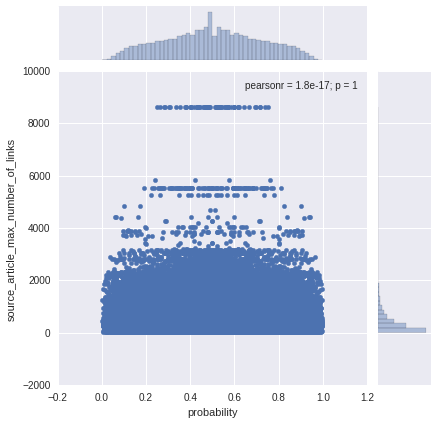

In [111]:
sns.jointplot(x='probability', y='source_article_max_number_of_links', data=data)

Let's again look at the contour plot for the 90th percentile.

/home/alexis/Applications/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


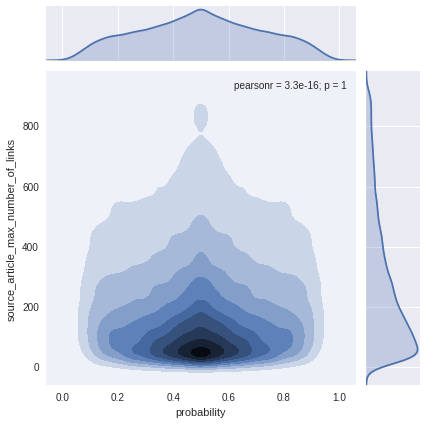

In [112]:
data_filt = data[data.source_article_max_number_of_links < data.source_article_max_number_of_links.quantile(.9)]
sns.jointplot(x='probability', y='source_article_max_number_of_links', data=data_filt, kind='kde');

## Feature `target_in_table`

This feature requires a slightly different approach for visualisation, since it is categorical (or actually boolean). 

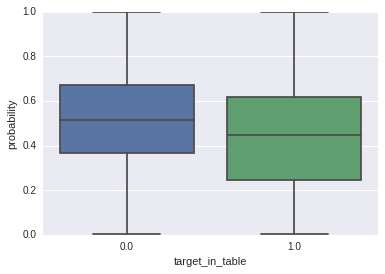

In [102]:
sns.boxplot(x="target_in_table", y="probability", data=data);

Both categories have a median around 0.5, but as we can see, the box for category $1$ is slightly below the other, for each quartile.

This difference becomes more visible when looking at a violinplot of the two (combines the boxplot with a kernel density estimation). It's hard to draw meaningful insight into the data itself from this though.

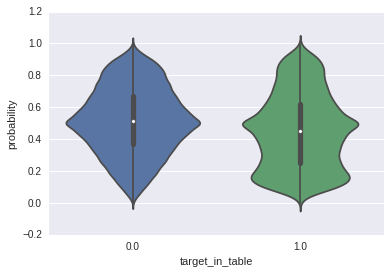

In [135]:
sns.violinplot(x="target_in_table", y="probability", data=data);

Overall, this evaluation of the features tells us that there is little predictive value in them. They have mostly very week correlations to the output data and very similar distributions amongst themselves, which is far from ideal, when trying to train a model to solve such a problem.

# Let's regress
## Baseline regressor
To start out, let's see how well a baseline regressor performs. We'll do this with a dummy regressor that always guesses a probability of 0.5.

In [136]:
from sklearn.dummy import DummyRegressor

In [137]:
dummy = DummyRegressor(strategy='constant', constant=0.5)
